<a href="https://colab.research.google.com/github/nikita24383/Apscript/blob/main/FE_SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Extraction of Individual File

In [1]:
from google.colab import files
uploaded = files.upload()

Saving OAF_back_angry.wav to OAF_back_angry (1).wav


In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [3]:
audio_path = "OAF_back_angry.wav"
x, sr = librosa.load(audio_path)
print(x,sr)

[-1.0417719e-05 -1.9059131e-04 -2.8630142e-04 ...  1.6136018e-04
  1.0805293e-04  0.0000000e+00] 22050


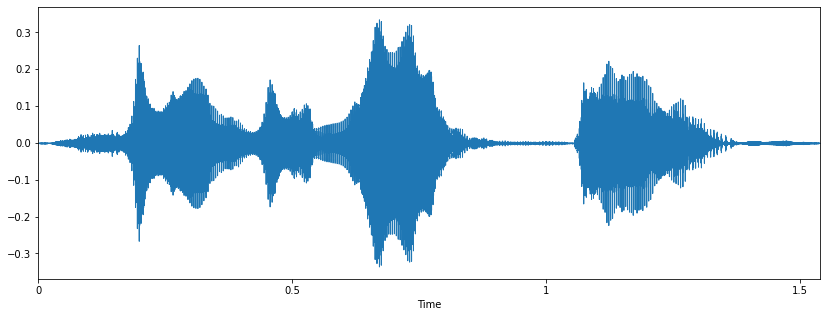

In [4]:
# zero crossing gate
plt.figure(figsize=(14,5))
librosa.display.waveplot(x,sr=sr)

[[ -0.77186096   1.1566334   -3.5512938  ...   7.213312     2.7855968
    0.12944715]
 [ -8.58168     -3.1996279   -0.73542416 ...   1.3768793   -2.4773593
   -8.345458  ]
 [-24.727839    -7.665888    -1.2120132  ...  -3.5454714  -11.230916
  -13.3662815 ]
 ...
 [-41.24357    -41.24357    -41.24357    ... -41.24357    -41.24357
  -41.24357   ]
 [-41.24357    -41.24357    -41.24357    ... -41.24357    -41.24357
  -41.24357   ]
 [-41.24357    -41.24357    -41.24357    ... -41.24357    -41.24357
  -41.24357   ]]


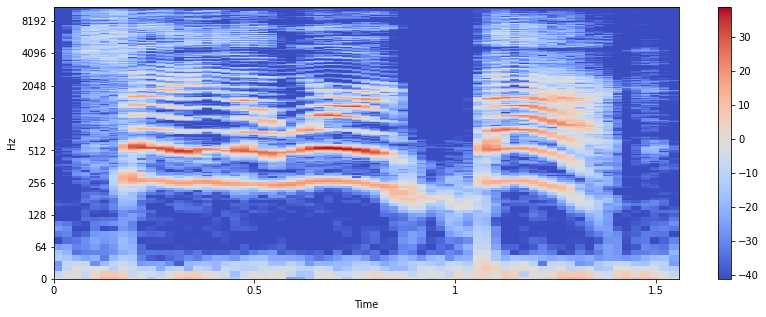

In [5]:
# for the amplitude at different times
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
print(Xdb)
plt.figure(figsize=(14,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

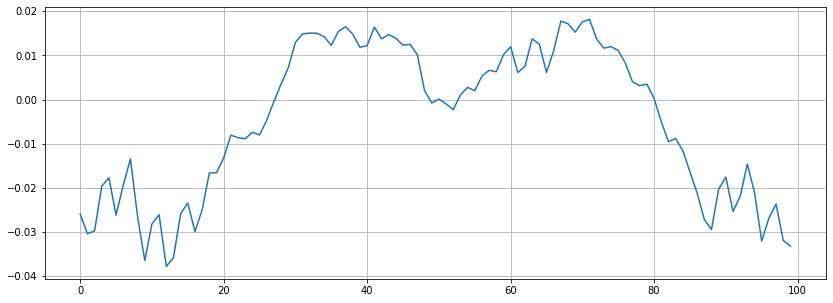

In [8]:
# zooming in
n0 = 9000
n1 = 9100
plt.figure(figsize=(14,5))
plt.plot(x[n0:n1])
plt.grid()

In [9]:
# calculate zero crossings
zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))

6


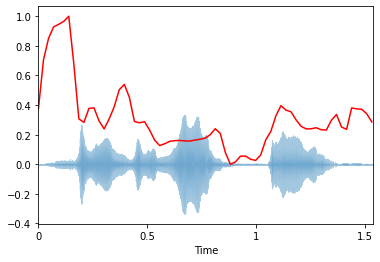

In [10]:
# Spectral centroid
import sklearn
spectral_centroid = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroid.shape

# computing time variable for visualization
frames = range(len(spectral_centroid))
t = librosa.frames_to_time(frames)

# Normalizing for visualization
def normalize(x, axis=0):
  return sklearn.preprocessing.minmax_scale(x, axis=axis)

# plotting spectral central along with waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroid), color='r')

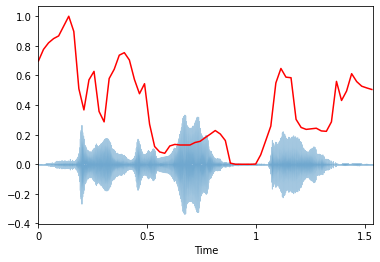

In [11]:
# spectral rolloff
spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

(20, 67)


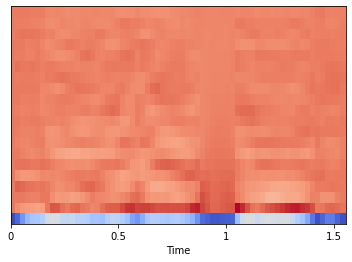

In [12]:
# MFCC
mfccs = librosa.feature.mfcc(x, sr=sr)
print(mfccs.shape)

# Display MFCCS
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

# Feature Extraction of Dataset

In [13]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Model
from keras import models
from keras import layers

In [14]:
header = 'filename chroma_stft rms spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

audio_fpath = "drive/MyDrive/speech-emotion-recognition-tess-data/"
audio_clips = os.listdir(audio_fpath)

# iterate through the folder
for filename in range(0,710):

  emotion = (audio_clips[filename].split("_")[-1]).split(".")[0]

  x, sr = librosa.load(audio_fpath+audio_clips[filename], sr=44100)
  chroma_stft = librosa.stft(x)
  rms = librosa.feature.rms(x)
  spec_cent = librosa.feature.spectral_centroid(x, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(x, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(x, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(x)
  mfcc = librosa.feature.mfcc(x, sr=sr)

  to_append = f'{audio_clips[filename]} {float(np.mean(chroma_stft))} {float(np.mean(rms))} {float(np.mean(spec_cent))} {float(np.mean(spec_bw))} {float(np.mean(rolloff))} {float(np.mean(zcr))}'    
  for m in mfcc:
      to_append += f' {float(np.mean(m))}'
  to_append += f' {emotion}'
  file = open('data.csv', 'a', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(to_append.split())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


In [17]:
# Reading a dataset
data = pd.read_csv('data.csv')
data.head()

# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)
data.head()

# encode emotions into integers
emotion_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(emotion_list)
print(emotion_list[0:7])

0      angry
1         ps
2    neutral
3    disgust
4        sad
5         ps
6    neutral
Name: label, dtype: object


In [18]:
# normalizing
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [19]:
# splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
# print(len(y_pred))
# for i in range(len(y_pred)):
#   print(y_test[i], "    ", y_pred[i], "\n")

In [21]:
# Keras Sequential Model
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

Epoch 1/20
5/5 [==============================] - 1s 5ms/step - loss: 2.1674 - accuracy: 0.2839
Epoch 2/20
5/5 [==============================] - 0s 5ms/step - loss: 1.5712 - accuracy: 0.7708
Epoch 3/20
5/5 [==============================] - 0s 4ms/step - loss: 0.9912 - accuracy: 0.9032
Epoch 4/20
5/5 [==============================] - 0s 4ms/step - loss: 0.5240 - accuracy: 0.9464
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - loss: 0.2486 - accuracy: 0.9659
Epoch 6/20
5/5 [==============================] - 0s 4ms/step - loss: 0.1151 - accuracy: 0.9816
Epoch 7/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9867
Epoch 8/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0504 - accuracy: 0.9884
Epoch 9/20
5/5 [==============================] - 0s 5ms/step - loss: 0.0321 - accuracy: 0.9944
Epoch 10/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0272 - accuracy: 0.9924
Epoch 11/20
5/5 [======================

In [33]:
# training accuracy
train_loss, train_acc = model.evaluate(X_train,y_train)
print('Train_acc: ',train_acc)

test_loss, test_acc = model.evaluate(X_test,y_test)
print('Test_acc: ',test_acc)

loss, acc = model.evaluate(X_test, y_pred)
print('Accuracy: ',acc)

18/18 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Train_acc:  1.0
5/5 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 1.0000
Test_acc:  1.0
5/5 [==============================] - 0s 3ms/step - loss: 0.1293 - accuracy: 0.9648
Accuracy:  0.9647887349128723


In [26]:
predictions = model.predict(X_test)
np.argmax(predictions)

512

In [27]:
# naive bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 96.47887323943662


In [29]:
from sklearn.metrics import confusion_matrix
print("confusion matrix")
confusion_matrix(y_test, y_pred)

confusion matrix


array([[20,  0,  0,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0,  0],
       [ 0,  0, 19,  0,  0,  0,  0],
       [ 1,  0,  0, 17,  0,  0,  0],
       [ 0,  0,  0,  0, 19,  0,  4],
       [ 0,  0,  0,  0,  0, 25,  0],
       [ 0,  0,  0,  0,  0,  0, 19]])

In [30]:
# Recall
print("Recall")
from sklearn.metrics import recall_score
recall_score(y_test, y_pred, average=None)

Recall


array([1.        , 1.        , 1.        , 0.94444444, 0.82608696,
       1.        , 1.        ])

In [31]:
# Precision
print("Precision")
from sklearn.metrics import precision_score
precision_score(y_test, y_pred, average=None)

Precision


array([0.95238095, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.82608696])